# Signal denoising using RNNs in PyTorch

In this post, I'll use PyTorch to create a simple Recurrent Neural Network (RNN) for denoising a signal. I started learning RNNs using PyTorch. However, I felt that many of the examples were fairly complex. So, here's an attempt to create a simple example.

### Problem description

Given a noisy sine wave as an input, we want to estimate the denoised signal. This is shown in the figure below.

![](denoising.png)

### Customary imports

In [1]:
import numpy as np
import math, random
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(0)

### Creating noisy and denoised signals

Let's now write functions to cerate a sine wave, add some noise on top of it. This way we're able to create a noisy verison of the sine wave.

In [108]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)+2

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise+10

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out

Let's now invoke the functions we defined to generate the figure we saw in the problem description.

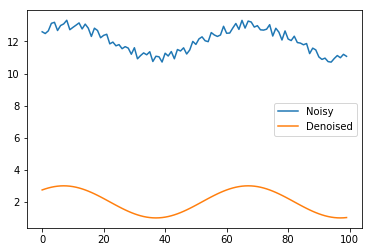

In [109]:
inp, out = sample(100)
plt.plot(inp, label='Noisy')
plt.plot(out, label ='Denoised')
plt.legend()

### Creating dataset

Now, let's write a simple function to generate a dataset of such noisy and denoised samples.

In [110]:
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

Now, creating the dataset, and dividing it into train and test set.

In [111]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_inp)
data_inp_scaled = scaler.transform(data_inp)
data_out_scaled = scaler.transform(data_out)

In [112]:
data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

In [113]:
import torch
import torch.nn as nn
from torch.autograd import Variable

### Creating RNN

We have 1d sine waves, which we want to denoise. Thus, we have input dimension of 1. Let's create a simple 1-layer RNN with 25 hidden units. 

In [123]:
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.linear(pred).view(pred.data.shape[0], -1, 1)
        return pred


In [124]:
r= CustomRNN(input_dim, hidden_size, 1)

In [125]:
list(r.parameters())[5].size()

torch.Size([1])

In [141]:
input_dim = 1
hidden_size = 45
num_layers = 1
rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers
, batch_first=True)
# We'll use TanH activaton
tanh = nn.Tanh()
relu = nn.ReLU()
linear = nn.Linear(hidden_size, 1)

### Training

In [142]:
r= CustomRNN(input_dim, hidden_size, 1)
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(200):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%2==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

0 1.418552041053772
2 0.640697181224823
4 0.7416679859161377
6 0.6632755994796753
8 0.6147423982620239
10 0.6418255567550659
12 0.6188149452209473
14 0.5980509519577026
16 0.5782493948936462
18 0.565689742565155
20 0.5347281098365784
22 0.503415048122406
24 0.46207910776138306
26 0.3920835852622986
28 0.480284720659256
30 0.6375488042831421
32 0.558197021484375
34 0.38742339611053467
36 0.387906551361084
38 0.4131935238838196
40 0.30313819646835327
42 0.3335677683353424
44 0.34548476338386536
46 0.2438851147890091
48 0.16551734507083893
50 0.24013876914978027
52 0.2916643023490906
54 0.27149298787117004
56 0.24396340548992157
58 0.23896560072898865
60 0.19549529254436493
62 0.1523866057395935
64 0.22843188047409058
66 0.22128863632678986
68 0.17655517160892487
70 0.1569146066904068
72 0.1495760977268219
74 0.19700373709201813
76 0.1587100327014923
78 0.14661994576454163
80 0.17125478386878967
82 0.15856115520000458
84 0.13956224918365479
86 0.16632601618766785
88 0.13788530230522156
90

Great. As expected, the loss reduces over time.

In [143]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)


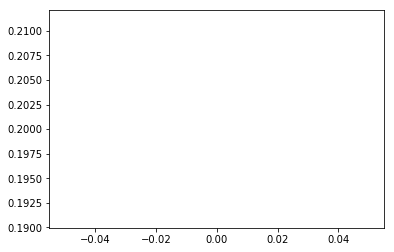

In [132]:
plt.plot(list(r.parameters())[5].data.numpy())

TypeError: Invalid dimensions for image data

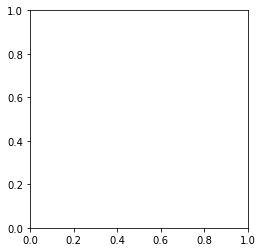

In [133]:
plt.imshow(list(r.parameters())[5].data.numpy())

In [134]:
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])
print(loss_func(t_inp, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

0.14140084385871887
9.999841690063477


### Visualising sample denoising

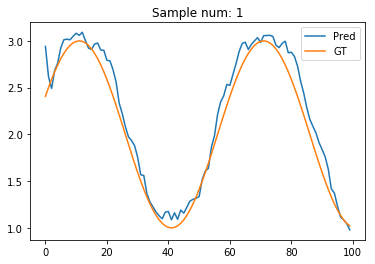

In [144]:
sample_num = 1
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

Seems pretty neat to me!

### Visualising estimations as model improves

Let's now write a simple function to visualise the estimations as a function of iterations. We'd expect the estimations to improve over time.

In [14]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(i):
    label = 'Iteration {0}'.format(i)
    ax.cla()
    ax.plot(np.array(predictions)[i, 0, :, 0].T, label='Pred')
    ax.plot(train_out[0, :], label='GT')
    ax.legend()
    ax.set_title(label)
 

anim = FuncAnimation(fig, update, frames=range(0, 200), interval=10)
anim.save('learning.mp4',fps=20)
plt.close()

fig size: 72.0 DPI, size in inches [ 4.  3.]


In [15]:
from IPython.display import Video
Video("learning.mp4")

This looks great! We can see how our model learns to learn reasonably good denoised signals over time. It doesn't start great though. Would a better initialisation help? I certainly feel that for this particular problem it would, as predicting the output the same as input is a good starting point!

I must also thank Simon Wang and his helpful inputs on the [PyTorch discussion forum](https://discuss.pytorch.org/t/problem-with-vanilla-rnn/12235/12).